# Extended hybrid training

Ok, so while I'm waiting for the extended hybrid from Francesco, I wanted to make a few intiution plots to see if I would expect this new hybrid training sample to be helping me or not.

- Evolution of $n_{trks}^{HF}$ and $n_{trks}^{frag}$ as a function of jet $p_T$
- The performance of a model trained on a dedicated extended Z' sample c.f. a model trained on the standard hybrid sample

As of 5am on Jan 31, I'm processing a training extended Z' sample, so we'll see how it looks when it's done!

In [2]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

import h5py

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Evaluate all of the models on the relevant training sets

The idea is, to evaluate the extended hybrid training, I want to ensure that I have as good (or at least compatible) performance for the standard and dedicated sample trainings.


In [3]:
jetCollection = 'VR'
trJetCol = 'VR'
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"

nFeatures=13
figDir = '../../figures/'


Evaluating on ttbar
Initialize method from myModel()
Loading previously trained LSTM
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
../../models/mc16d_VR_ttbar/LSTM_200units_10dense_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
../../models/mc16d_VR_hybrid_1.5TeV_cut_125GeV/LSTM_300units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
.

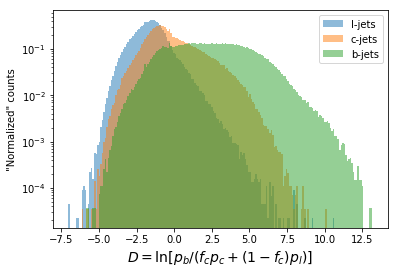

Initialize method from myModel()
Loading previously trained LSTM
../../models/mc16d_VR_Zprime_1.5TeV/LSTM_200units_10dense_3mtrain_25trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev
Load in the previously saved efficiency file

Evaluating on Zprime_5TeV_2lead
Initialize method from myModel()
Loading previously trained LSTM
../../models/mc16d_VR_ttbar/LSTM_200units_10dense_2mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev
Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
../../models/mc16d_VR_hybrid_1.5TeV_cut_125GeV/LSTM_300units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev

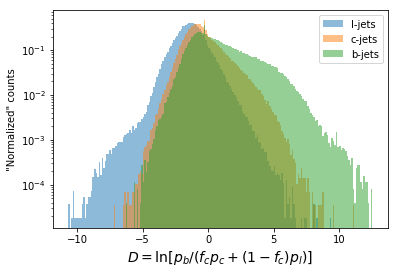

Initialize method from myModel()
Loading previously trained LSTM
../../models/mc16d_VR_Zprime_1.5TeV/LSTM_200units_10dense_3mtrain_25trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev
Load in the previously saved efficiency file


In [4]:
leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

for physicsSample, nTrks_te, miniJetTag in zip(['ttbar','Zprime_1.5TeV_2lead','Zprime_5TeV_2lead'],
                                               [15,25,25],['2m','1000k','1000k']):
        
    print('\nEvaluating on '+physicsSample)
        
    for trainPhysicsSample, Ntrain, nHidden, nTrks_tr, nClasses in \
        zip(['ttbar','hybrid_1.5TeV_cut_125GeV','hybrid_5TeV_cut_125GeV','Zprime_1.5TeV'],#,'Zprime_5TeV'],
            [int(2e6),int(3e6),int(3e6),int(3e6),int(3e6)], [200,300,500,200,200], [15,15,15,25,25],
            [4,3,3,4,3]):

        # Load in the sample for evaluation
        subDir = 'mc16d_{}_{}'.format(jetCollection,physicsSample)
        dataDir = '../../data/'+subDir
        scale_tag = "_{}_scale".format(trainPhysicsSample) if physicsSample != trainPhysicsSample else ""

        dataTagTest = "{}test_{}trks_{}_sd0_rev{}".format(miniJetTag,nTrks_te,vStr, scale_tag)

        f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
        f = h5py.File(f_name,"r")

        X = f['X_test'][:]
        y = f['y_test'][:]
        ix = f['ix_test'][:]

        f.close()

        # If we're evaluating the model that has been trained on 
        nTest = X.shape[0]
        if nTrks_te > nTrks_tr:
            # Restrict the # of tracks you're evaluating with
            X = X[:,:nTrks_tr,:]
        if nTrks_te < nTrks_tr:
            # Append 0s
            zeros = np.zeros((nTest,nTrks_tr-nTrks_te,nFeatures))
            X = np.concatenate((X,zeros),axis=1)

        # Also open the df so that you'll have access to the jet pt and eta
        jet_df = pd.read_hdf('{}/jet_{}test_{}trks_sd0_rev.h5'.format(dataDir,miniJetTag,nTrks_te), key='jet_df')

        # Only keep the events without taus, since these models were only trained w/ 
        # 3 output classes
        if nClasses == 3:
            notaus = (y != 3)
            X  = X[notaus]
            y  = y[notaus]
            ix = ix[notaus]

            pt = jet_df.pt.values[notaus]
            eta = jet_df.eta.values[notaus]

        else:
            pt = jet_df.pt.values
            eta = jet_df.eta.values

        # Load in the model
        modelDir = "../../models/mc16d_{}_{}".format(trJetCol,trainPhysicsSample)
        dataTagTrain = "{}train_{}trks_{}_sd0_rev".format(nJetsTag(Ntrain),nTrks_tr,vStr)
        m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, 
                   loadModel=True,nClasses=nClasses,timeSteps=nTrks_tr)

        print(m.modelDir+"/"+m.modelName)
        
        # Get the efficiencies
        tag = '_eval_{}_pt_10GeV'.format(physicsSample) if physicsSample != trainPhysicsSample else ''
        if trainPhysicsSample == 'hybrid_5TeV_cut_125GeV' and physicsSample != 'ttbar':
            (leff, ceff, beff), d = sigBkgEff(m, X, y, ix, returnDisc=True,
                                              figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)            
        else:
            (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                            figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)

        discs.append(d)
        labels.append('train {}, eval {}'.format(trainPhysicsSample,physicsSample))

        ys.append(y)
        pts.append(pt)
        etas.append(eta)



### $t\bar{t}$

In [5]:
binomialErrors = True

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
../../plottingFcts.py:609: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


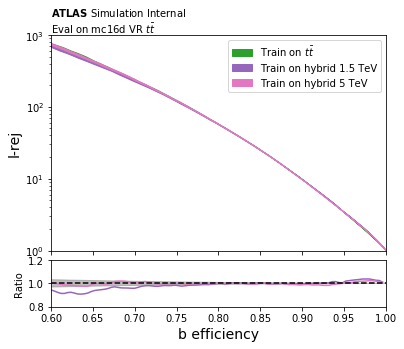

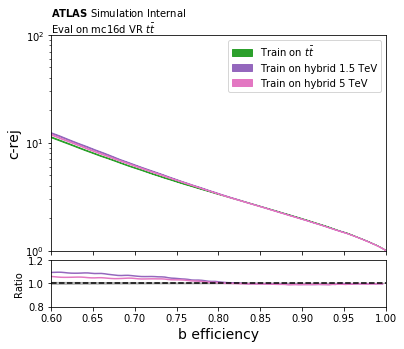

In [6]:
train_labels=['Train on {}'.format(x) for x in [r'$t\bar{t}$','hybrid 1.5 TeV','hybrid 5 TeV','Z\' 1.5 TeV']]#,'Z\' 5 TeV']]

subDir = 'mc16d_VR_ttbar'
plotTag1 = 'rej_cf_ext_hyb'
plotTag2 = plotTag1+'_Zprime'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $t\bar{t}$"

colors = ['C2','C4','C6','C0','C1']

ntests = [np.sum(ys[0]==label) for label in range(3) ]

plotROCRatio(beffs[:3], leffs[:3], train_labels[:3], rrange=(0.8,1.2),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=binomialErrors,nTest=ntests[0], 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag1)

plotROCRatio(beffs[:3], ceffs[:3], train_labels[:3], rrange=(0.8,1.2),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=binomialErrors,nTest=ntests[1], 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag1)

In [7]:
ntests

[751790, 127407, 562182]

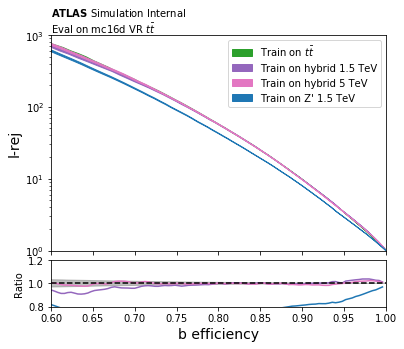

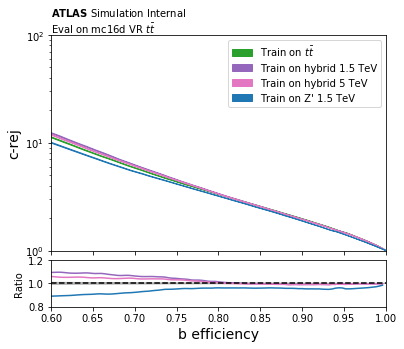

In [8]:
plotROCRatio(beffs[:4], leffs[:4], train_labels, rrange=(0.8,1.2),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=binomialErrors,nTest=ntests[0], 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag2)

plotROCRatio(beffs[:4], ceffs[:4], train_labels, rrange=(0.8,1.2),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=binomialErrors,nTest=ntests[1], 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag2)

When evaluating on $t\bar{t}$, there's some loss in performance for l-rej with the extended hybrid training, so I think I just need to increase the complexity of this extended model.

#### $p_T$ and $\eta$ dependence

l (0, 1000)
c (0, 20)
b (0, 1)


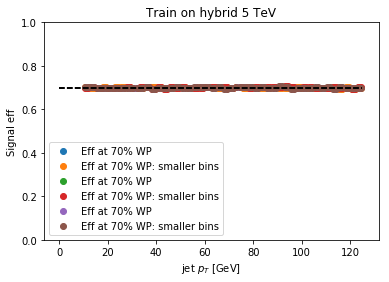

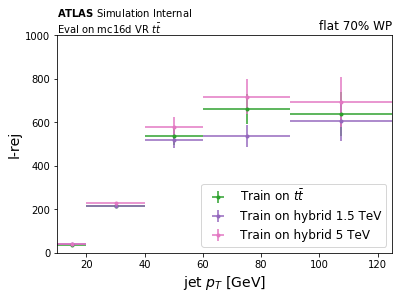

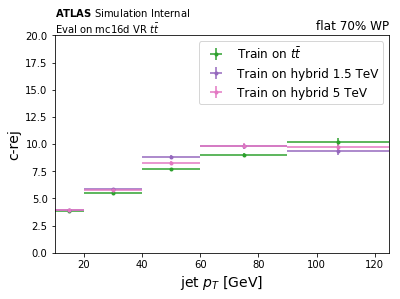

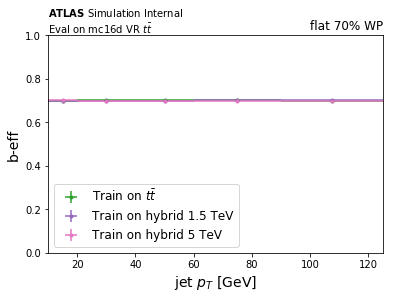

In [9]:
tag1 = 'cf_ext_hyb'
tag2 = tag1+'_Zprime'

plotPtDependence(pts[:3],ys[:3],discs[:3], train_labels[:3],
                 lrej_lim=(0,1000),crej_lim=(0,20),beff_lim=(0,1),
                 flat=True,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.array([10, 20, 40, 60, 90, 125]),
                 eff_bins = np.arange(10,127.5,2.5),
                 figDir=figDir,subDir=subDir,tag=tag1,verbose=False)

l (0, 1000)
c (0, 20)
b (0, 1)


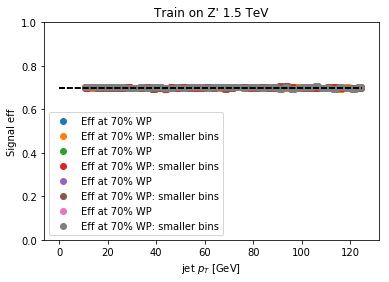

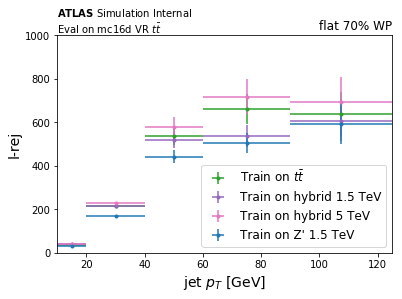

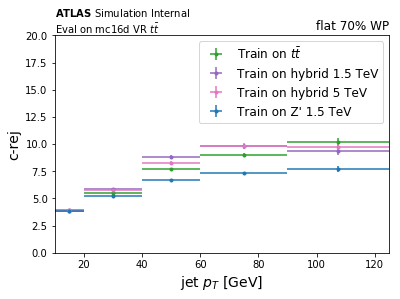

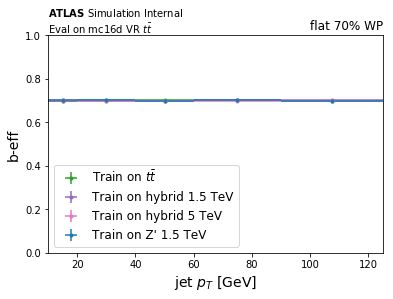

In [10]:
plotPtDependence(pts[:4],ys[:4],discs[:4], train_labels,
                 lrej_lim=(0,1000),crej_lim=(0,20),beff_lim=(0,1),
                 flat=True,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.array([10, 20, 40, 60, 90, 125]),
                 eff_bins = np.arange(10,127.5,2.5),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False)

### Fixed $p_T$

l (0, 1000)
c (0, 20)
b (0, 1)


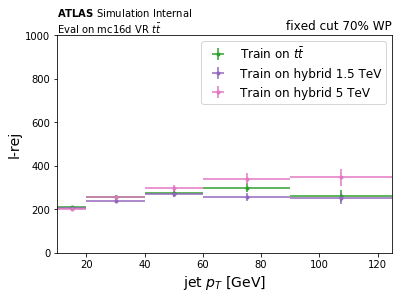

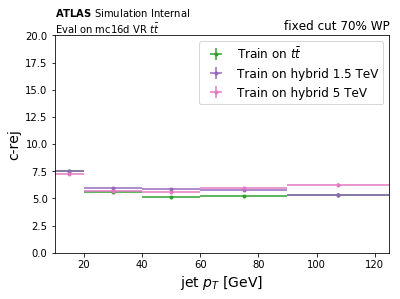

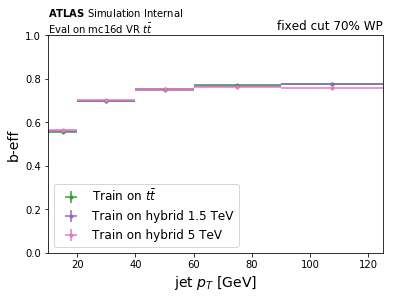

In [11]:
tag1 = 'cf_ext_hyb'
tag2 = tag1+'_Zprime'

plotPtDependence(pts[:3],ys[:3],discs[:3], train_labels[:3],
                 lrej_lim=(0,1000),crej_lim=(0,20),beff_lim=(0,1),
                 flat=False,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.array([10, 20, 40, 60, 90, 125]),
                 eff_bins = np.arange(10,127.5,2.5),
                 figDir=figDir,subDir=subDir,tag=tag1,verbose=False)

l (0, 1000)
c (0, 20)
b (0, 1)


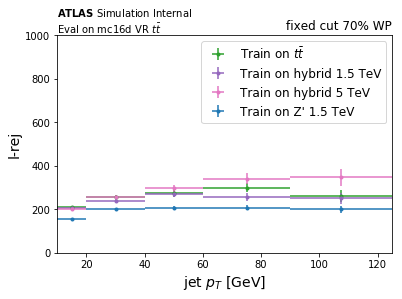

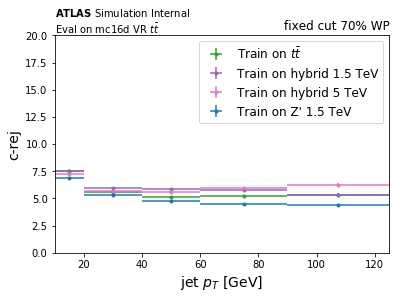

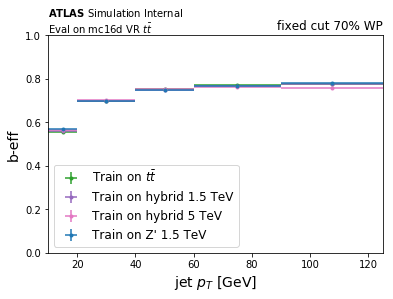

In [12]:
plotPtDependence(pts[:4],ys[:4],discs[:4], train_labels,
                 lrej_lim=(0,1000),crej_lim=(0,20),beff_lim=(0,1),
                 flat=False,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.array([10, 20, 40, 60, 90, 125]),
                 eff_bins = np.arange(10,127.5,2.5),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False)

### $\eta$ dependent performance plots

l (0, 450)
c (0, 10)
b (0, 1)


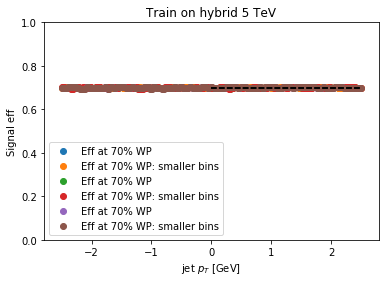

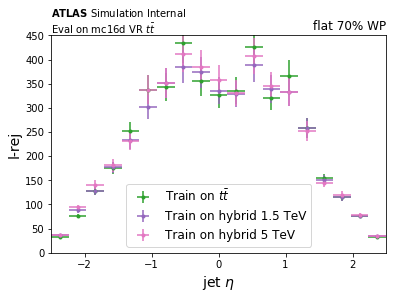

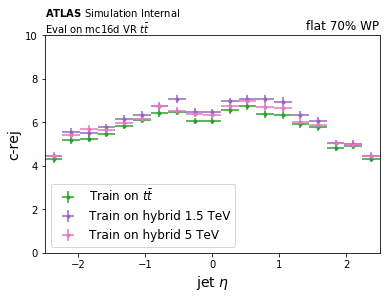

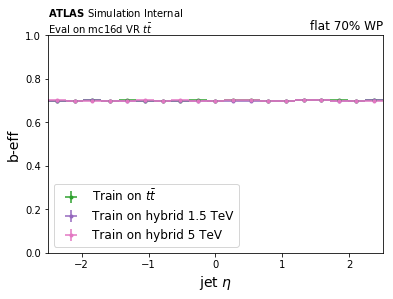

In [13]:
eta_min = -2.5
eta_max =  2.5

plotPtDependence(etas[:3],ys[:3],discs[:3], train_labels[:3], xlabel='jet $\eta$',
                 lrej_lim=(0,450),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag1,
                 var='eta',verbose=False)

l (0, 450)
c (0, 10)
b (0, 1)


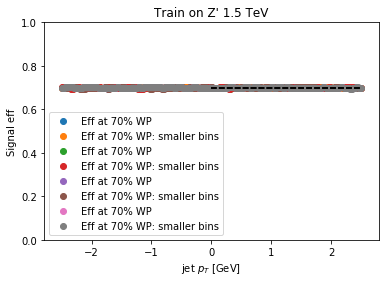

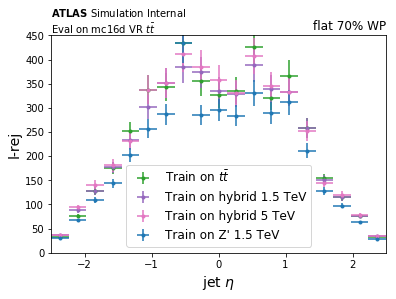

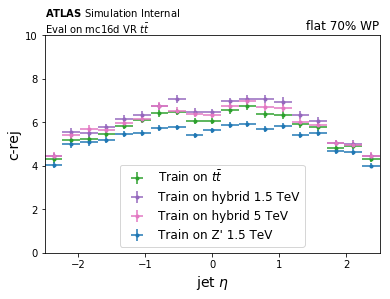

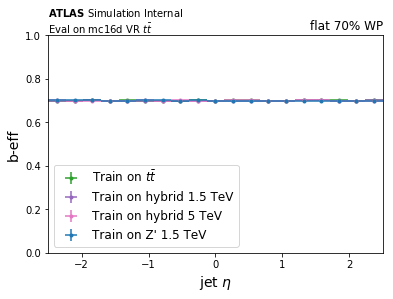

In [14]:
plotPtDependence(etas[:4],ys[:4],discs[:4], train_labels,xlabel='jet $\eta$',
                 lrej_lim=(0,450),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag2,
                 var='eta',verbose=False)

### Z': 1.5 TeV

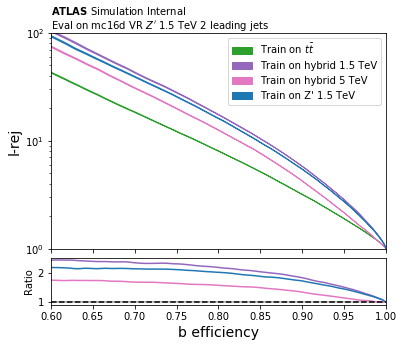

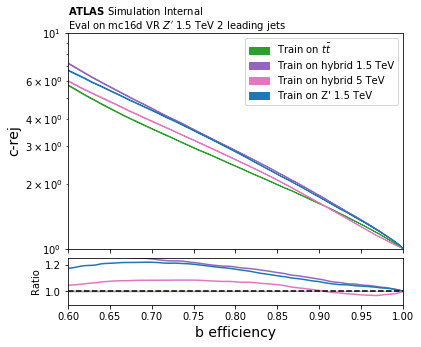

In [15]:
subDir = 'mc16d_VR_Zprime_1.5TeV_2lead'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $Z'$ 1.5 TeV 2 leading jets"

ntests = [np.sum(ys[5]==label) for label in range(3) ]

plotROCRatio(beffs[4:8], leffs[4:8], train_labels, rrange=(0.9,2.5),ymax=100,
             text=text,ylabel='l-rej',binomialErrors=binomialErrors,nTest=ntests[0], 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag1)

plotROCRatio(beffs[4:8], ceffs[4:8], train_labels, rrange=(0.9,1.25),ymax=10,
             text=text,ylabel='c-rej',binomialErrors=binomialErrors,nTest=ntests[1], 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag1)

#### $p_T$ and $\eta$ dependence

l (0, 100)
c (0, 10)
b (0, 1)


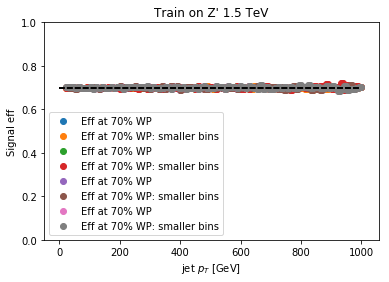

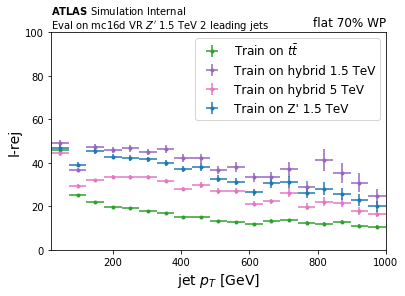

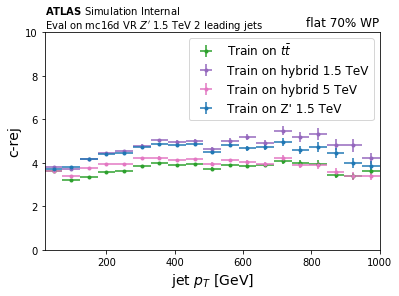

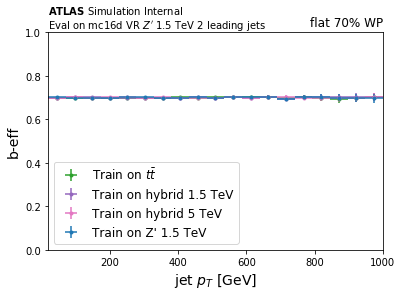

In [16]:
ptmin = 20
ptmax = 1000

plotPtDependence(pts[4:8],ys[4:8],discs[4:8],train_labels,
                 lrej_lim=(0,100),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False)

l (0, 100)
c (0, 10)
b (0, 1)


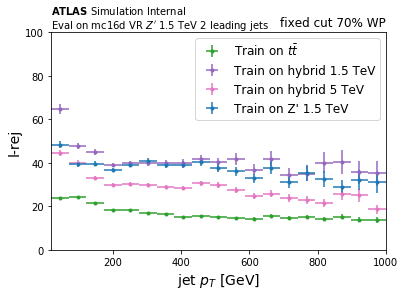

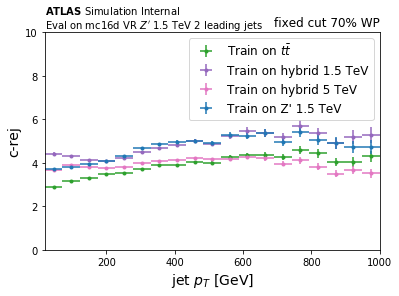

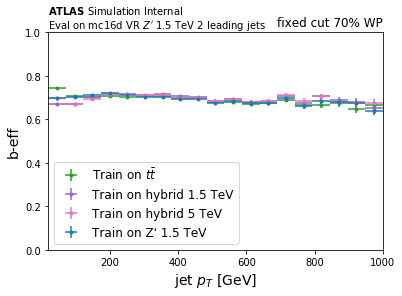

In [17]:
plotPtDependence(pts[4:8],ys[4:8],discs[4:8],train_labels,
                 lrej_lim=(0,100),crej_lim=(0,10),beff_lim=(0,1),
                 flat=False,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False)

l (0, 100)
c (0, 10)
b (0, 1)


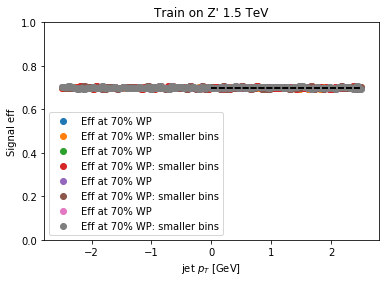

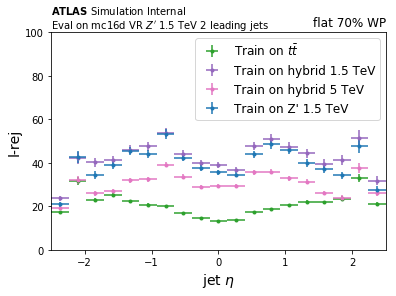

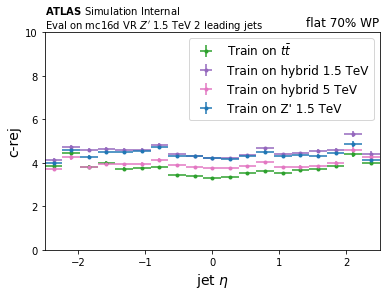

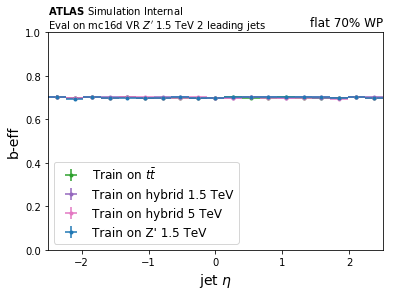

In [18]:
plotPtDependence(etas[4:8],ys[4:8],discs[4:8], train_labels,xlabel='jet $\eta$',
                 lrej_lim=(0,100),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag2,var='eta',verbose=False)

### Z': 5 TeV

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:1830: RuntimeWarning: invalid value encountered in double_scalars
  c[-q-1] = yb[q] / spec.poch(n - q, q) * (-1)**q * (xb - xa)**q


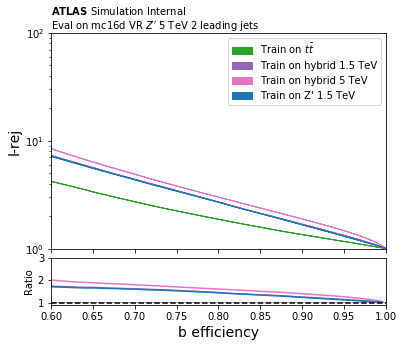

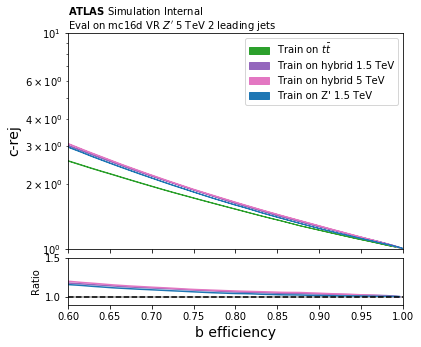

In [19]:
subDir = 'mc16d_VR_Zprime_5TeV_2lead'

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d VR $Z'$ 5 TeV 2 leading jets"

ntests = [np.sum(ys[10]==label) for label in range(3) ]

plotROCRatio(beffs[8:], leffs[8:], train_labels, rrange=(0.9,3),ymax=100,
             text=text,ylabel='l-rej',binomialErrors=binomialErrors,nTest=ntests[0], 
             colors=colors, figDir=figDir,subDir=subDir,tag='l'+plotTag2)

plotROCRatio(beffs[8:], ceffs[8:], train_labels, rrange=(0.9,1.5),ymax=10,
             text=text,ylabel='c-rej',binomialErrors=binomialErrors,nTest=ntests[1], 
             colors=colors, figDir=figDir,subDir=subDir,tag='c'+plotTag2)

#### $p_T$ and $\eta$ dependence

l (0, 20)
c (0, 10)
b (0, 1)


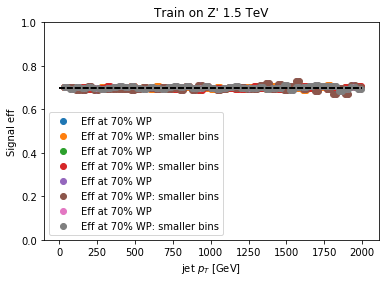

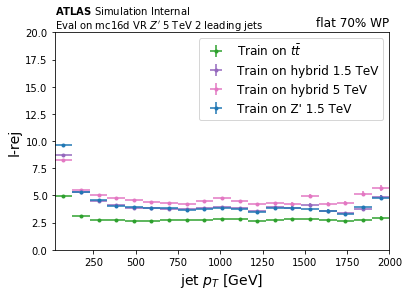

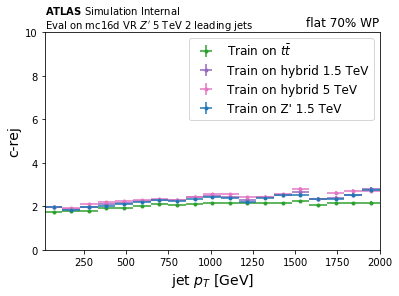

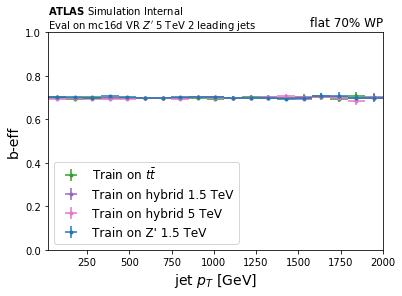

In [20]:
ptmax=2000
plotPtDependence(pts[8:],ys[8:],discs[8:],train_labels,
                 lrej_lim=(0,20),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,50),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False)

l (0, 20)
c (0, 10)
b (0, 1)


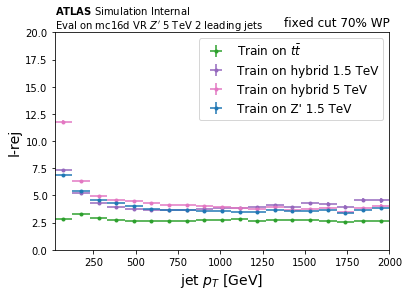

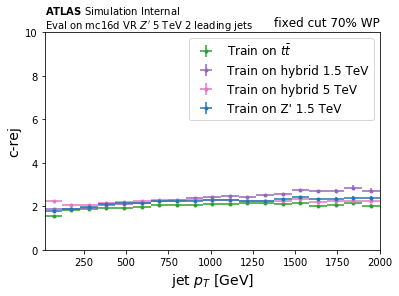

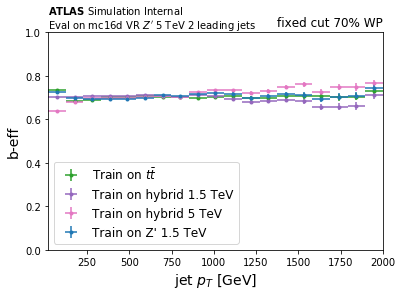

In [21]:
plotPtDependence(pts[8:],ys[8:],discs[8:],train_labels,
                 lrej_lim=(0,20),crej_lim=(0,10),beff_lim=(0,1),
                 flat=False,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins=np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag2,verbose=False)

l (0, 20)
c (0, 10)
b (0, 1)


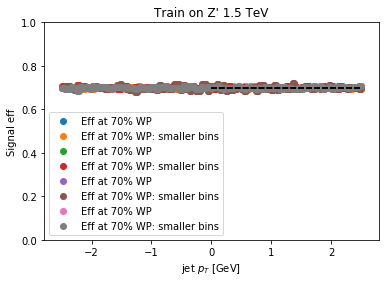

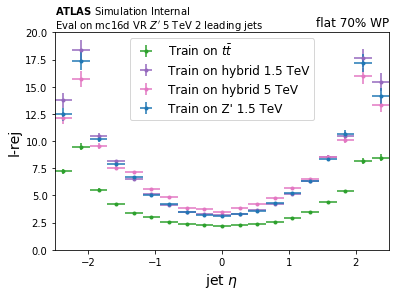

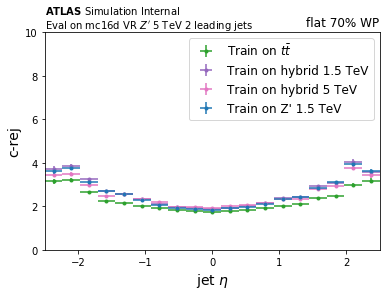

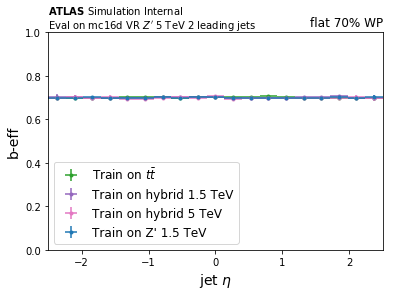

In [22]:
plotPtDependence(etas[8:],ys[8:],discs[8:],train_labels,xlabel='jet $\eta$',
                 lrej_lim=(0,20),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=binomialErrors,colors=colors,text=text,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins=np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir,tag=tag1,var='eta',verbose=False)

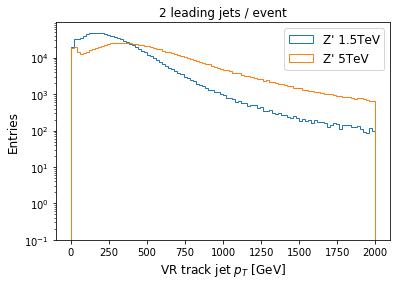

In [24]:
for i, l in zip([4,8],['Z\' 1.5TeV','Z\' 5TeV']):

    plt.hist(pts[i],100,(0,2000),label=l,histtype='step',log=True)
    
plt.xlabel('VR track jet $p_T$ [GeV]',fontsize=12)
plt.ylabel('Entries',fontsize=12)
plt.legend(fontsize=12)
plt.title('2 leading jets / event')
plt.savefig('../../figures/mc16d_VR_Zprime_5TeV_2lead/pt_log.pdf')
plt.show()